We will be exploring the *relative entropy* or Kullback-Leibler divergence (KL).

$$ D_{q}(p) = \mathbb{E}_{p}\bigg[\log\frac{p(x)}{q(x)}\bigg] $$

To build an intuition about what this important quantity is computing we examine the right hand side more closely. For continuous random vairables the KL is computed as follows

\begin{align}
\mathbb{E}_{p}\bigg[\log\frac{p(x)}{q(x)}\bigg] & = \int p(x) \log \frac{p(x)}{q(x)} dx \\
& = -\int p(x) \log \frac{q(x)}{p(x)} dx \\
& = -\int p(x) \log q(x) dx - \bigg(-\int p(x) \log p(x) \bigg ) dx\\
& = H_q(p) - H(p) \\
\end{align}

$H(p)$ is the entropy of $p$, or average amount of information received when observing a value from $p$. $H_q(p)$ is the cross entropy which is how much more information we need to represent an observation from $q$ by $p$. The KL is their difference, a measure of how imprecise we are when describing events from $p$ with $q$. In terms of inference KL measures what we gain by changing our prior from $q$ to $p$.

Let's take a look at how the KL changes as a function of some simple distributions. Let's let $p$ be a bimodal mixture of gaussians and q, a unimodal gaussian.

\begin{align}
p(x) & = \frac{2}{5}\mathcal{N}(x\lvert -3,1) + \frac{3}{5}\mathcal{N}(x,\lvert 3,1) \\
q(x) & = \mathcal{N}(x \lvert 0,1) \\
\end{align}

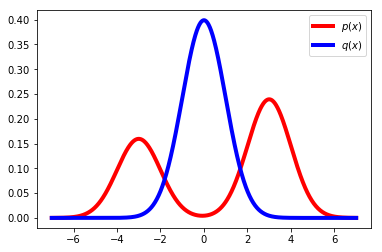

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interactive
from scipy.stats import norm
import numpy as np

class gmm: # gaussian mixture model
    
    def __init__(self, pis, params):
        self.params = params # [[mu1, sig1], [mu2, sig2],...]
        self.components = params.shape[0]
        self.pis = pis
        
    def __call__(self, x):
        pis = self.pis
        p = self.params
        sz = self.components
        return np.array([pis[i]*norm.pdf(x,*(p[i])) for i in range(sz)]).sum(axis=0)
    
    def sample(self, n_samples):
        mode_id = np.random.choice(self.components, size=n_samples, replace=True)
        return np.array([norm.rvs(*(self.params[i])) for i in mode_id]) 

    
p = gmm([0.4,0.6], np.array([[-3,1],[3,1]]))
q = gmm([1], np.array([[0,1]]))


fig, ax = plt.subplots(1, 1)
x = np.linspace(-7,7,1000)
ax.plot(x, p(x), c='r', lw=4, label='$p(x)$')
ax.plot(x, q(x), c='b', lw=4, label='$q(x)$')
ax.legend()
plt.show()

To calculate $D_q(p)$ we observe that the integral must be evaluated over all values of the sample space. Often times we cannot calculate the integral analytically. However with a sufficiently large sample $N$ we can approximate it

\begin{align}
D_q(p) & = \int_a^b p(x) \log \frac{p(x)}{q(x)} dx \\
& \approx \frac{b-a}{N} \sum_{n=1}^N p(x_n) \log \frac{p(x_n)}{q(x_n)}
\end{align}

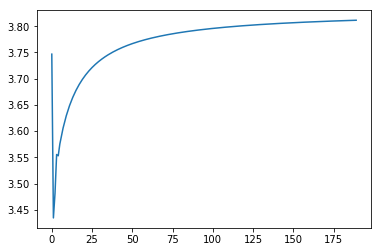

In [20]:
def forward_kl_int(p,q,n_samples):
    a = -10
    b = 10
    samples = np.linspace(a,b,n_samples)
    ps = p(samples)
    return (ps*np.log(ps/q(samples))).sum()*((b-a)/n_samples)

kls = []
for i in range(10,200):
   kls.append(forward_kl_int(p,q,i))

plt.plot(kls);
plt.show()

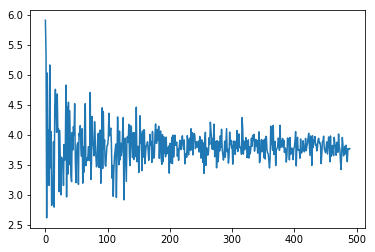

In [16]:
def forward_kl_samp(p,q,n_samples):
    samples = p.sample(n_samples)
    ps = p(samples)
    return np.log(ps/q(samples)).sum()/n_samples

kls = []
for i in range(10,500):
   kls.append(forward_kl_samp(p,q,i))

plt.plot(kls);
plt.show()

Let us examine how the KL changes as we modify the parameters of $q$

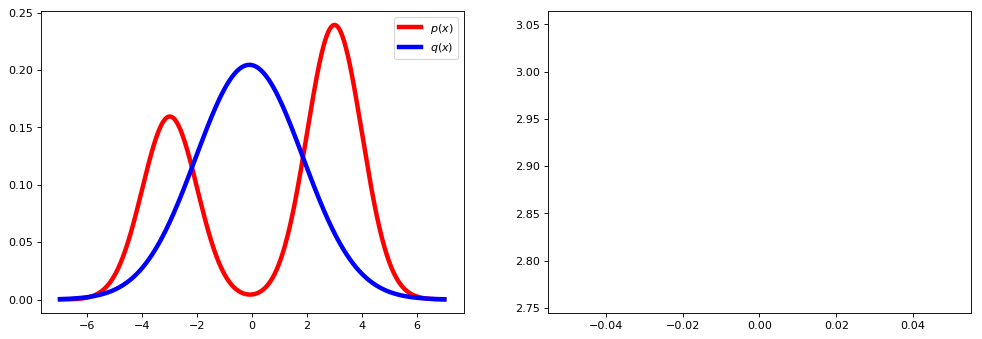

In [19]:
x = np.linspace(-7,7,1000)
kls = []

def f(mu, sig):
    q = gmm([1], np.array([[mu,sig]]))
    kl = forward_kl_int(p,q,200)
    kls.append(kl)
    fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=80)
    ax[0].plot(x, p(x), c='r', lw=4, label='$p(x)$')
    ax[0].plot(x, q(x), c='b', lw=4, label='$q(x)$')
    ax[0].legend()
    ax[1].plot(kls)
    plt.show()

interactive_plot = interactive(f, mu=(-3, 3, 0.1), sig=(0.05, 4, 0.1))
output = interactive_plot.children[-1]
output.layout.height = '35px'
interactive_plot

We find the minimum occurs when the mean of $q$ is between the two means of $p$. We can begin to see why this is by examining $D_q(p)$. We reproduce it here for reference.

\begin{align}
D_q(p) & = \int p(x) \log \frac{p(x)}{q(x)} dx \\
& = H_q(p) - H(p) \\
\end{align}

Noticing that the entropy of $p$, $H(p)$, does not depend on $q$ we see that minimizing $D_q(p)$ with respect to $q$ amounts to minimizing the cross entropy term $H_q(p)$ with respect to $q$.

\begin{equation}
H_q(p) = \int p(x) \log \frac{1}{q(x)} dx \\
\end{equation}

When $p$ is small, the logarithm term will not contribute much to the integral. To keep the integral small then, we need the logarithm term to be small when $p$ is large. In other words $D_q(p)$ is minimized when $q$ is chosen to be as large as possible whenever $p$ is large. Because $q$ is unimodal, this is achieved when $q$ is between the peaks of the mixture model and has high tails. This way it allocates high probability density on both modes.

### Forward vs Reverse KL

When $q$ is the variable distribution, $D_q(p)$ is called the *forward KL*. The forward KL tells us how inefficient it us for us to represent $q$ by $p$. So by minimizing the KL with respect to $q$ we found the optimal distribution $q^*$ that $p$ could represent. This is often not the goal in machine learning. More often we are presented with a distribution, or samples from it, and would like to find the optimal distribution to represent it. This is the reverse problem, and it can be conveniently expressed using the *reverse KL*, $D_p(q)$.

\begin{align}
D_p(q) & = \int q(x) \log \frac{q(x)}{p(x)} dx \\
& = H_p(q) - H(q) \\
\end{align}

It is important to note that we interpret the KL as either forward or reverse soley by which distribution is free. 

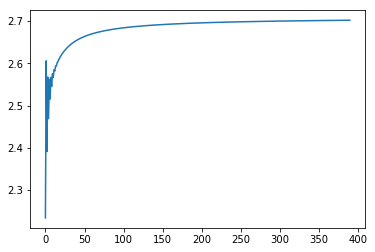

In [11]:
def reverse_kl_int(q,p,n_samples):
    a = -7
    b = 7
    samples = np.linspace(a,b,n_samples)
    qs = q(samples)
    return (qs*np.log(qs/p(samples))).sum()*((b-a)/n_samples)

kls = []
for i in range(10,400):
   kls.append(reverse_kl_int(q,p,i))

plt.plot(kls);
plt.show()

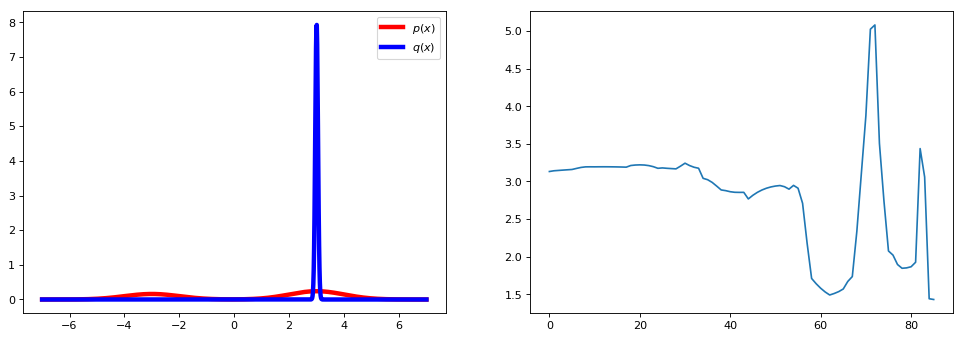

In [10]:
x = np.linspace(-7,7,1000)
kls = []

def f(mu, sig):
    q = gmm([1], np.array([[mu,sig]]))
    kl = reverse_kl_int(q,p,2000)
    kls.append(kl)
    fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=80)
    ax[0].plot(x, p(x), c='r', lw=4, label='$p(x)$')
    ax[0].plot(x, q(x), c='b', lw=4, label='$q(x)$')
    ax[0].legend()
    ax[1].plot(kls)
    plt.show()

interactive_plot = interactive(f, mu=(-3, 3, 0.1), sig=(0.05, 6, 0.1))
output = interactive_plot.children[-1]
output.layout.height = '35px'
interactive_plot

Code from Tuan Anh Le's Blog for showing the difference between Forward and Reverse KL. Blog - http://www.tuananhle.co.uk/notes/reverse-forward-kl.html

In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt


class GaussianMixture1D:
    def __init__(self, mixture_probs, means, stds):
        self.num_mixtures = len(mixture_probs)
        self.mixture_probs = mixture_probs
        self.means = means
        self.stds = stds

    def sample(self, num_samples=1):
        mixture_ids = np.random.choice(self.num_mixtures, size=num_samples, p=self.mixture_probs)
        result = np.zeros([num_samples])
        for sample_idx in range(num_samples):
            result[sample_idx] = np.random.normal(
                loc=self.means[mixture_ids[sample_idx]],
                scale=self.stds[mixture_ids[sample_idx]]
            )
        return result

    def logpdf(self, samples):
        mixture_logpdfs = np.zeros([len(samples), self.num_mixtures])
        for mixture_idx in range(self.num_mixtures):
            mixture_logpdfs[:, mixture_idx] = scipy.stats.norm.logpdf(
                samples,
                loc=self.means[mixture_idx],
                scale=self.stds[mixture_idx]
            )
        return sp.misc.logsumexp(mixture_logpdfs + np.log(self.mixture_probs), axis=1)

    def pdf(self, samples):
        return np.exp(self.logpdf(samples))


def approx_kl(gmm_1, gmm_2, xs):
    ys = gmm_1.pdf(xs) * (gmm_1.logpdf(xs) - gmm_2.logpdf(xs))
    return np.trapz(ys, xs)


def minimize_pq(p, xs, q_means, q_stds):
    q_mean_best = None
    q_std_best = None
    kl_best = np.inf
    for q_mean in q_means:
        for q_std in q_stds:
            q = GaussianMixture1D(np.array([1]), np.array([q_mean]), np.array([q_std]))
            kl = approx_kl(p, q, xs)
            if kl < kl_best:
                kl_best = kl
                q_mean_best = q_mean
                q_std_best = q_std

    q_best = GaussianMixture1D(np.array([1]), np.array([q_mean_best]), np.array([q_std_best]))
    return q_best, kl_best


def minimize_qp(p, xs, q_means, q_stds):
    q_mean_best = None
    q_std_best = None
    kl_best = np.inf
    for q_mean in q_means:
        for q_std in q_stds:
            q = GaussianMixture1D(np.array([1]), np.array([q_mean]), np.array([q_std]))
            kl = approx_kl(q, p, xs)
            if kl < kl_best:
                kl_best = kl
                q_mean_best = q_mean
                q_std_best = q_std

    q_best = GaussianMixture1D(np.array([1]), np.array([q_mean_best]), np.array([q_std_best]))
    return q_best, kl_best


def main():
    p_second_means_min = 0
    p_second_means_max = 10
    num_p_second_means = 5
    p_second_mean_list = np.linspace(p_second_means_min, p_second_means_max, num_p_second_means)

    p = [None] * num_p_second_means
    q_best_forward = [None] * num_p_second_means
    kl_best_forward = [None] * num_p_second_means
    q_best_reverse = [None] * num_p_second_means
    kl_best_reverse = [None] * num_p_second_means

    for p_second_mean_idx, p_second_mean in enumerate(p_second_mean_list):
        p_mixture_probs = np.array([0.5, 0.5])
        p_means = np.array([0, p_second_mean])
        p_stds = np.array([1, 1])
        p[p_second_mean_idx] = GaussianMixture1D(p_mixture_probs, p_means, p_stds)

        q_means_min = np.min(p_means) - 1
        q_means_max = np.max(p_means) + 1
        num_q_means = 20
        q_means = np.linspace(q_means_min, q_means_max, num_q_means)

        q_stds_min = 0.1
        q_stds_max = 5
        num_q_stds = 20
        q_stds = np.linspace(q_stds_min, q_stds_max, num_q_stds)

        trapz_xs_min = np.min(np.append(p_means, q_means_min)) - 3 * np.max(np.append(p_stds, q_stds_max))
        trapz_xs_max = np.max(np.append(p_means, q_means_min)) + 3 * np.max(np.append(p_stds, q_stds_max))
        num_trapz_points = 1000
        trapz_xs = np.linspace(trapz_xs_min, trapz_xs_max, num_trapz_points)

        q_best_forward[p_second_mean_idx], kl_best_forward[p_second_mean_idx] = minimize_pq(
            p[p_second_mean_idx], trapz_xs, q_means, q_stds
        )
        q_best_reverse[p_second_mean_idx], kl_best_reverse[p_second_mean_idx] = minimize_qp(
            p[p_second_mean_idx], trapz_xs, q_means, q_stds
        )

    # plotting
    fig, axs = plt.subplots(nrows=1, ncols=num_p_second_means, sharex=True, sharey=True)
    fig.set_size_inches(8, 1.5)
    for p_second_mean_idx, p_second_mean in enumerate(p_second_mean_list):
        xs_min = -5
        xs_max = 15
        num_plot_points = 1000
        xs = np.linspace(xs_min, xs_max, num_plot_points)
        axs[p_second_mean_idx].plot(xs, p[p_second_mean_idx].pdf(xs), label='$p$', color='black')
        axs[p_second_mean_idx].plot(xs, q_best_forward[p_second_mean_idx].pdf(xs), label='$\mathrm{argmin}_q \,\mathrm{KL}(p || q)$', color='black', linestyle='dashed')
        axs[p_second_mean_idx].plot(xs, q_best_reverse[p_second_mean_idx].pdf(xs), label='$\mathrm{argmin}_q \,\mathrm{KL}(q || p)$', color='black', linestyle='dotted')

        axs[p_second_mean_idx].spines['right'].set_visible(False)
        axs[p_second_mean_idx].spines['top'].set_visible(False)
        axs[p_second_mean_idx].set_yticks([])
        axs[p_second_mean_idx].set_xticks([])

    axs[2].legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 0), fontsize='small')
    filenames = ['reverse_forward_kl.pdf', 'reverse_forward_kl.png']
    for filename in filenames:
        fig.savefig(filename, bbox_inches='tight', dpi=200)
        print('Saved to {}'.format(filename))


if __name__ == '__main__':
    main()

/Users/nathancrock/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:32: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


Saved to reverse_forward_kl.pdf
Saved to reverse_forward_kl.png


$$I(x) = -\log p(x)$$

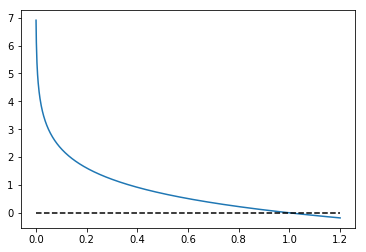

In [7]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0.001,1.2,1000)
y = -np.log(x)
plt.plot(x,y)
plt.plot([0,1.2],[0,0],ls='dashed',c='k')
plt.show()

$$ H(p) = \mathbb{E}_{p}\big[-\log p(x)\big] = \int p(x) \big(- \log p(x) \big) dx$$

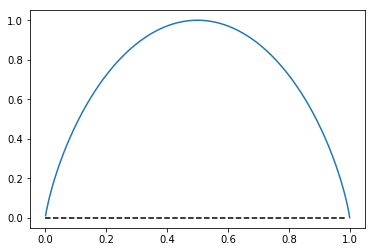

In [15]:
x = np.linspace(0.001,0.9999,1000)
y = x*(-np.log2(x)) + (1-x)*(-np.log2(1-x))
plt.plot(x,y)
plt.plot([0,0.99],[0,0],ls='dashed',c='k')
plt.show()

$$ \min_{q(x)} KL(q(x)||p(x)) $$